<a href="https://colab.research.google.com/github/julianovale/PO240_Meta_heuristica/blob/main/PO240_TrabalhoFinal_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solver do OR-Tools do Google

In [6]:
! pip install ortools

In [7]:
"""Simple travelling salesman problem on a circuit board."""

import pandas as pd
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(url):
    """Stores the data for the problem."""
#    url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/VoxTrebleBosster.txt'
    df = pd.read_csv(url)
    data = {}
    data['locations'] = [tuple(row) for row in df.values]
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {},'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Objective: {}m\n'.format(route_distance)


def solver(url):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(url)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    distance_matrix = compute_euclidean_distance_matrix(data['locations'])

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.log_search = True

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)


#if __name__ == '__main__':
#    main()

# Simulated Annealing

In [8]:
###################################################################################################

#  Algoritmo desenvolvido por Juliano Vale e Matheus Evangelista
#  Baseado em aula de otimização para função contínua (função de Himmelblau) do curso "Optimization  
#  with metaheuristics in Python" - Profa. Dana Bani-Hani - Binghamton University (NY - USA)
#  https://www.udemy.com/course/optimization-with-metaheuristics/

###################################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

# função copiada de https://github.com/Valdecy/Summary
def caminho(coordinates, city_tour):
    xy = np.zeros((len(city_tour), 2))
    for i in range(0, len(city_tour)):
        if (i < len(city_tour)):
            xy[i, 0] = coordinates[int(city_tour[i]-1), 0]
            xy[i, 1] = coordinates[int(city_tour[i]-1), 1]
        else:
            xy[i, 0] = coordinates[int(city_tour[0]-1), 0]
            xy[i, 1] = coordinates[int(city_tour[0]-1), 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return


# função copiada de https://developers.google.com/optimization/routing/tsp
# Essa função é interessante para placa de circuito impresso, trabalha com espaço plano. NÃO USAR PARA CIDADES!!!
# para cidades utilizar alguma função de geocodificação
def compute_euclidean_distance_matrix(locations): 
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances


def SA(coordenadas, T0 = 1000, M = 250, N = 5, Alpha = 0.9):

  df = pd.read_csv(coordenadas)
  Y = df.values

  distancias = compute_euclidean_distance_matrix(Y)

  teste1 = pd.DataFrame.from_dict(distancias, orient='index')

  Data1 = teste1

  
  # X0 = [6, 7, 8, 9, 14, 18, 21, 20, 22, 23, 24, 19, 13, 17, 16, 15, 10, 12, 11, 3, 2, 1, 0, 4, 5, 6]
  X0 = np.arange(len(teste1)).tolist() # solução inicial aleatória
  X0 = random.sample(X0, len(X0))
  X0.append(X0[0])
  print(X0)

  ### NÃO SÃO MAIS CIDADES... SÃO PONTOS NA PLACA DE CIRCUITO IMPRESSO: TROCAR NOME DAS VARIÁVEIS? NÃO PRECISA!

  Distances = [] 
  t = 0
  for i in range(len(X0)-1):
      X1 = Data1.loc[X0[t],X0[t+1]] # cada localidade e a localidade após
      X11 = Data1.loc[X0[-1],X0[0]] # a útlima cidade para a primeira cidade
      Distances.append(X1) 
      t = t+1

  Distances.append(X11) # adiciona o últino trajeto 
  distanciainicial = sum(Distances) # soma das distâncias

  print("Solução inicial: ", distanciainicial)

  ### parametros ### Já pus na def, comentar

  # T0 = 3000
  # M = 1000
  # N = 50
  # Alpha = 0.85

  TempIni = T0 # para impressão do gráfico final

  # Para gerar visualização
  Temp = []
  Min_Distance = []


  for i in range(M):
      for j in range(N):
          # Gerando inteiros para fazer a troca de "cidades"
          Ran1 = np.random.randint(0,len(X0))
          Ran2 = np.random.randint(0,len(X0))
          while Ran1 == Ran2:
              Ran2 = np.random.randint(0,len(X0))
          
          Xtemp = []
          A1 = X0[Ran1] # cidade 1 para trocar
          A2 = X0[Ran2] # cidade 2 para trocar
          
          # Fazendo uma nova lista de cidades
          w = 0
          for i in X0:
              if X0[w]==A1:
                  Xtemp=np.append(Xtemp,A2)
              elif X0[w]==A2:
                  Xtemp=np.append(Xtemp,A1)
              else:
                  Xtemp=np.append(Xtemp,X0[w])
              w = w+1
          
          Xtemp = list(Xtemp)
          
          Distances_X0 = [] # a função objetivo da atual solução
          t = 0
          for i in range(len(X0)-1):
              X1_1 = Data1.loc[X0[t],X0[t+1]] 
              X11 = Data1.loc[X0[-1],X0[0]] 
              Distances_X0.append(X1_1) 
              t = t+1
          
          Distances_X0.append(X11) 
          Len_X0 = sum(Distances_X0) 
          
          ### Esse trecho do código está repetitivo... criar uma def (se der tempo!!!)
          Distances_Xtemp = [] # A FO da solução (n+1)
          t = 0 
          for i in range(len(Xtemp)-1):
              X1_2 = Data1.loc[Xtemp[t],Xtemp[t+1]] 
              X11 = Data1.loc[Xtemp[-1],Xtemp[0]] 
              Distances_Xtemp.append(X1_2) 
              t = t+1
          
          Distances_Xtemp.append(X11)
          Len_Xtemp = sum(Distances_Xtemp)
          
          
          rand_num = np.random.rand() # cria um número aleatório 
          form_1 = 1/(np.exp((Len_Xtemp-Len_X0)/T0)) # o pulo do gato (no código anterior não funcionava): ACEITA MUDANÇA?
          
          if Len_Xtemp <= Len_X0: # se a solução potencial é melhor (menor, no caso)
              X0 = Xtemp
          
          elif rand_num <= form_1: # se o número aleatório gerado na linha 118 for menor.
              X0 = Xtemp
          
          else: # não aceita a potencial solução e fica onde está
              X0 = X0
              
      Temp = np.append(Temp, T0) # para visualização
      Min_Distance = np.append(Min_Distance,Len_Xtemp) # para visualização
      
      T0 = Alpha*T0 # reduz a temperatura

  print
  print
  print("Solução final: ", X0)
  print("A distância obtida na solução final é: ", Len_X0)
  print
  print

  eixox = np.arange(1, TempIni+1, TempIni/M)
  eixox[::-1]
  plt.plot(eixox, Min_Distance)
  plt.title('Distância x Temperatura')
  plt.xlabel("Temperatura")
  plt.ylabel("Distância")
  plt.show()

  return X0

# Instância 1: Vox Treble Booster (25 pontos)




In [ ]:
### OR-Tools

%%time
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/VoxTrebleBosster.txt'
solver(url)

Objective: 34
Route:
 0, 4, 12, 17, 13, 7, 8, 9, 14, 19, 18, 24, 23, 22, 21, 20, 16, 15, 10, 11, 5, 6, 3, 2, 1, 0

CPU times: user 28.5 s, sys: 492 ms, total: 29 s
Wall time: 30.2 s


[18, 6, 17, 13, 8, 2, 1, 23, 0, 11, 16, 7, 4, 15, 3, 24, 12, 5, 10, 20, 21, 22, 9, 14, 19, 18]
Solução inicial:  75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in double_scalars


Solução final:  [9.0, 14.0, 17.0, 16.0, 11.0, 10.0, 15.0, 20.0, 21.0, 22.0, 23.0, 24.0, 18.0, 19.0, 13.0, 7.0, 6.0, 5.0, 12.0, 4.0, 0.0, 1.0, 2.0, 3.0, 8.0, 9.0]
A distância obtida na solução final é:  36


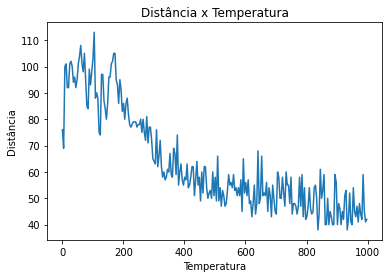

CPU times: user 5.21 s, sys: 49.3 ms, total: 5.26 s
Wall time: 5.32 s


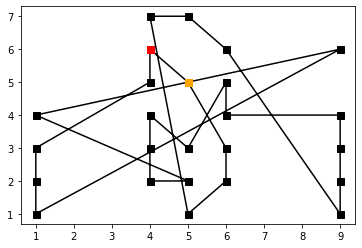

In [ ]:
### Simulated Annealing

%%time
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/VoxTrebleBosster.txt'
sa = SA(url)
df = pd.read_csv(url)
Y = df.values
caminho(Y, sa)

# Instância 2 - Echoplex Preamp (31 pontos)

In [22]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/EchoplexPreamp.txt'

In [23]:
### OR-Tools

%%time
solver(url)

Objective: 38
Route:
 0, 4, 1, 5, 8, 13, 22, 30, 26, 21, 20, 24, 28, 29, 25, 19, 16, 12, 7, 11, 18, 23, 27, 17, 15, 14, 10, 9, 6, 2, 3, 0

CPU times: user 28.9 s, sys: 385 ms, total: 29.3 s
Wall time: 30.1 s


[16, 9, 28, 1, 4, 0, 21, 12, 30, 5, 15, 26, 3, 6, 20, 17, 29, 2, 23, 24, 7, 22, 25, 27, 13, 10, 14, 18, 11, 19, 8, 16]
Solução inicial:  129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in double_scalars


Solução final:  [1.0, 5.0, 8.0, 7.0, 3.0, 15.0, 18.0, 19.0, 25.0, 28.0, 30.0, 26.0, 21.0, 22.0, 29.0, 24.0, 27.0, 23.0, 17.0, 14.0, 9.0, 6.0, 10.0, 16.0, 12.0, 13.0, 20.0, 11.0, 2.0, 0.0, 4.0, 1.0]
A distância obtida na solução final é:  52


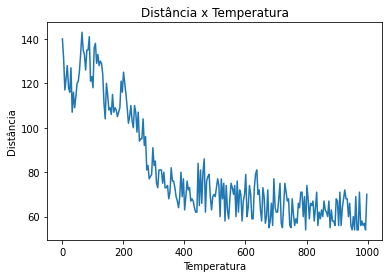

CPU times: user 6.46 s, sys: 74.4 ms, total: 6.53 s
Wall time: 6.59 s


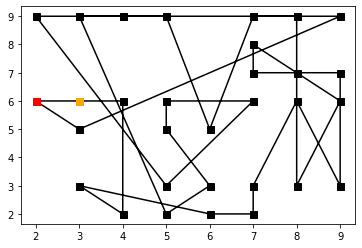

In [24]:
### Simulated Annealing

%%time
sa = SA(url)
df = pd.read_csv(url)
Y = df.values
caminho(Y, sa)

# Instância 3 - RAT (70 pontos)

In [25]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/RAT.txt'

In [13]:
### OR-Tools

%%time
solver(url)

Objective: 79
Route:
 0, 1, 6, 11, 16, 17, 20, 18, 12, 7, 2, 8, 3, 4, 14, 13, 22, 28, 46, 57, 56, 55, 53, 49, 45, 42, 35, 34, 26, 27, 21, 25, 33, 32, 31, 24, 30, 37, 39, 40, 41, 44, 48, 52, 51, 43, 50, 54, 47, 38, 36, 29, 23, 19, 15, 9, 10, 5, 0

CPU times: user 29.6 s, sys: 164 ms, total: 29.8 s
Wall time: 30.1 s


[17, 31, 23, 12, 13, 30, 47, 50, 32, 44, 10, 48, 21, 54, 55, 16, 22, 20, 38, 3, 45, 8, 56, 35, 39, 57, 41, 28, 14, 24, 36, 27, 0, 4, 18, 51, 11, 42, 7, 2, 33, 19, 15, 25, 49, 53, 43, 37, 1, 46, 34, 40, 29, 5, 6, 9, 26, 52, 17]
Solução inicial:  376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in double_scalars


Solução final:  [44.0, 54.0, 50.0, 38.0, 11.0, 2.0, 21.0, 45.0, 55.0, 53.0, 52.0, 48.0, 41.0, 30.0, 19.0, 15.0, 9.0, 5.0, 8.0, 4.0, 3.0, 14.0, 13.0, 7.0, 43.0, 47.0, 39.0, 40.0, 10.0, 0.0, 1.0, 6.0, 24.0, 31.0, 37.0, 32.0, 33.0, 18.0, 23.0, 29.0, 36.0, 51.0, 49.0, 57.0, 56.0, 35.0, 34.0, 26.0, 16.0, 12.0, 27.0, 42.0, 46.0, 28.0, 22.0, 20.0, 17.0, 25.0, 44.0]
A distância obtida na solução final é:  170


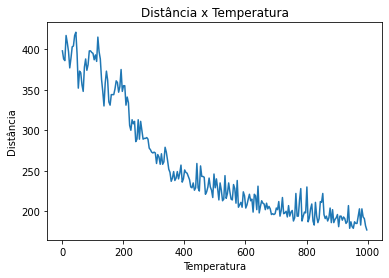

CPU times: user 11.8 s, sys: 76.9 ms, total: 11.8 s
Wall time: 12 s


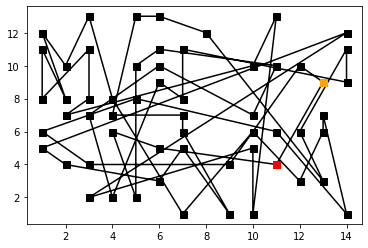

In [26]:
### Simulated Annealing

%%time
sa = SA(url)
df = pd.read_csv(url)
Y = df.values
caminho(Y, sa)

# Instância 4 - Fulltone OCD (82 pontos)

In [27]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/OCD.txt'

In [28]:
### OR-Tools

%%time
solver(url)

Objective: 100
Route:
 0, 3, 5, 10, 13, 18, 17, 22, 16, 15, 21, 27, 34, 35, 36, 37, 28, 23, 19, 14, 24, 25, 32, 31, 30, 38, 29, 39, 45, 44, 43, 42, 41, 47, 50, 49, 54, 61, 60, 62, 74, 69, 64, 65, 70, 75, 79, 78, 77, 73, 68, 63, 55, 51, 56, 57, 58, 67, 72, 81, 80, 76, 71, 66, 59, 52, 53, 48, 46, 40, 33, 26, 20, 12, 1, 9, 11, 8, 7, 6, 4, 2, 0

CPU times: user 29.7 s, sys: 114 ms, total: 29.8 s
Wall time: 30.1 s


[13, 35, 65, 55, 41, 15, 1, 71, 78, 74, 3, 32, 50, 59, 79, 14, 2, 36, 46, 60, 19, 7, 25, 30, 34, 49, 12, 22, 66, 16, 69, 54, 39, 47, 72, 81, 56, 42, 33, 37, 24, 5, 45, 28, 21, 64, 76, 80, 61, 27, 0, 29, 11, 23, 43, 73, 6, 52, 58, 67, 75, 51, 48, 57, 20, 8, 62, 53, 68, 17, 18, 31, 63, 4, 40, 77, 44, 38, 9, 26, 70, 10, 13]
Solução inicial:  542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in double_scalars


Solução final:  [58.0, 65.0, 74.0, 73.0, 49.0, 36.0, 22.0, 6.0, 16.0, 15.0, 21.0, 41.0, 51.0, 59.0, 67.0, 72.0, 52.0, 30.0, 37.0, 57.0, 42.0, 39.0, 26.0, 33.0, 56.0, 61.0, 63.0, 38.0, 43.0, 44.0, 45.0, 62.0, 68.0, 77.0, 69.0, 29.0, 13.0, 9.0, 1.0, 11.0, 23.0, 10.0, 7.0, 3.0, 2.0, 0.0, 4.0, 25.0, 32.0, 48.0, 46.0, 80.0, 81.0, 71.0, 78.0, 60.0, 54.0, 50.0, 28.0, 19.0, 18.0, 17.0, 27.0, 40.0, 31.0, 24.0, 34.0, 47.0, 64.0, 70.0, 79.0, 75.0, 66.0, 76.0, 53.0, 14.0, 12.0, 20.0, 8.0, 5.0, 35.0, 55.0, 58.0]
A distância obtida na solução final é:  253


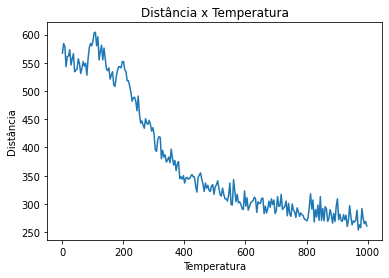

CPU times: user 16.2 s, sys: 76.8 ms, total: 16.2 s
Wall time: 16.3 s


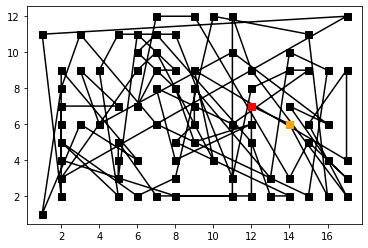

In [29]:
### Simulated Annealing

%%time
sa = SA(url)
df = pd.read_csv(url)
Y = df.values
caminho(Y, sa)

# Instância 5 - Blues Driver (157 pontos)

In [31]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/Blues%20driver.txt'

In [32]:
### OR-Tools

%%time
solver(url)

Objective: 202
Route:
 0, 10, 28, 29, 30, 31, 20, 32, 35, 42, 49, 58, 64, 75, 90, 95, 103, 113, 112, 102, 94, 89, 83, 74, 63, 73, 57, 62, 71, 72, 82, 88, 111, 110, 119, 125, 135, 147, 136, 126, 127, 118, 128, 137, 143, 148, 149, 150, 144, 138, 129, 130, 131, 120, 114, 104, 105, 96, 91, 79, 84, 68, 67, 55, 45, 46, 40, 48, 47, 60, 69, 70, 85, 80, 86, 92, 99, 108, 98, 107, 97, 106, 115, 121, 132, 139, 145, 151, 152, 153, 154, 155, 156, 146, 142, 124, 123, 122, 133, 140, 141, 134, 116, 109, 100, 117, 101, 93, 87, 81, 61, 56, 41, 27, 26, 19, 9, 8, 18, 7, 16, 6, 5, 4, 17, 34, 25, 24, 23, 33, 38, 39, 44, 52, 53, 54, 59, 66, 78, 77, 76, 65, 51, 50, 43, 37, 36, 22, 21, 15, 14, 3, 2, 1, 13, 12, 11, 0

CPU times: user 29.9 s, sys: 73 ms, total: 29.9 s
Wall time: 30.1 s


[29, 21, 38, 152, 133, 16, 50, 19, 70, 10, 153, 6, 60, 105, 54, 35, 5, 72, 110, 86, 83, 101, 28, 114, 108, 148, 59, 80, 33, 118, 66, 92, 0, 154, 155, 34, 31, 43, 123, 137, 95, 44, 94, 134, 156, 58, 45, 15, 91, 13, 112, 75, 37, 53, 47, 65, 100, 25, 115, 142, 36, 131, 89, 7, 39, 121, 135, 46, 52, 73, 151, 42, 97, 119, 104, 17, 129, 57, 51, 117, 12, 71, 139, 22, 55, 49, 78, 24, 14, 76, 106, 2, 124, 149, 4, 62, 132, 143, 79, 69, 147, 82, 130, 150, 48, 3, 23, 27, 111, 88, 85, 67, 141, 1, 63, 102, 77, 136, 90, 140, 145, 98, 30, 61, 87, 20, 84, 41, 146, 40, 81, 126, 120, 56, 32, 116, 103, 127, 11, 68, 26, 125, 128, 9, 122, 18, 113, 64, 144, 109, 96, 107, 8, 99, 74, 93, 138, 29]
Solução inicial:  1710


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in double_scalars


Solução final:  [23.0, 103.0, 114.0, 131.0, 74.0, 89.0, 96.0, 134.0, 105.0, 129.0, 137.0, 133.0, 99.0, 53.0, 38.0, 20.0, 82.0, 75.0, 44.0, 84.0, 98.0, 145.0, 115.0, 120.0, 101.0, 146.0, 142.0, 154.0, 48.0, 9.0, 18.0, 19.0, 55.0, 60.0, 40.0, 61.0, 69.0, 45.0, 108.0, 107.0, 83.0, 43.0, 49.0, 62.0, 144.0, 150.0, 63.0, 5.0, 21.0, 32.0, 110.0, 149.0, 88.0, 94.0, 76.0, 138.0, 100.0, 39.0, 140.0, 152.0, 139.0, 117.0, 132.0, 118.0, 113.0, 79.0, 27.0, 46.0, 4.0, 10.0, 30.0, 42.0, 58.0, 73.0, 71.0, 57.0, 130.0, 155.0, 156.0, 141.0, 125.0, 127.0, 136.0, 122.0, 81.0, 68.0, 116.0, 85.0, 80.0, 67.0, 93.0, 109.0, 124.0, 123.0, 87.0, 54.0, 65.0, 126.0, 112.0, 119.0, 111.0, 147.0, 102.0, 128.0, 64.0, 52.0, 36.0, 12.0, 29.0, 11.0, 25.0, 47.0, 16.0, 95.0, 90.0, 59.0, 34.0, 8.0, 17.0, 148.0, 135.0, 70.0, 26.0, 41.0, 56.0, 92.0, 121.0, 151.0, 153.0, 143.0, 104.0, 91.0, 78.0, 0.0, 28.0, 3.0, 15.0, 14.0, 51.0, 77.0, 106.0, 97.0, 66.0, 86.0, 50.0, 72.0, 35.0, 37.0, 13.0, 31.0, 33.0, 7.0, 6.0, 24.0, 22.0, 1.0,

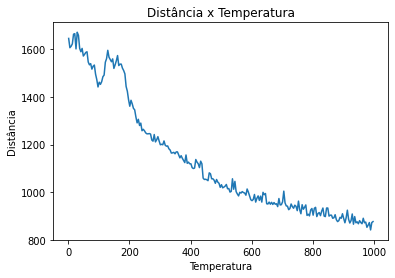

CPU times: user 30.4 s, sys: 167 ms, total: 30.6 s
Wall time: 30.6 s


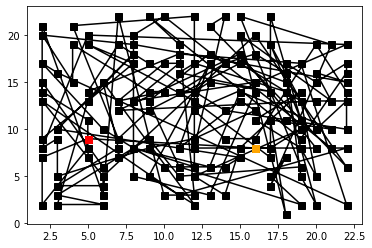

In [35]:
### Simulated Annealing

%%time
sa = SA(url)
df = pd.read_csv(url)
Y = df.values
caminho(Y, sa)